# Mapping the Spread of Coronavirus Covid-19 with python and Plotly
In this post I am going to share my recent experience on learning some visualizations in python and Plotly. Throught this sample, I am going to review the following skills:

* How to read a csv from web into a pandas dataframe (df) 
* How to make the dataframe _tidy_ 
* How to create timeseries plot in plotly 
* How to create an animated spatiotemporal map in plotly 

## Part 1. Preparing Data
In this part I am showing how to get the data from the repository of coronavirus spread throughout the world. [This repository](https://github.com/CSSEGISandData/COVID-19) is made available by Johns Hopkins University and is the datasource behind [this great visualization](https://www.arcgis.com/apps/opsdashboard/index.html#/bda7594740fd40299423467b48e9ecf6).

_Make sure to read the Terms of Service on the bottom of the github repository before starting to use the dataset_

In [1]:
import numpy as np

import geopandas as gpd
import pandas as pd
from functools import reduce


### 1.1. Downloading the Data
The main repository contains two sets of csv files in two separate folders. a folder contains daily csv files, and another folder contains timeseries of the daily data. Here, I am using the timeseries data of the number of Confirmed, Deaths, and Recovered cases into three pandas ddataframes.

In [2]:
#### Part 1 : Preparing the data

# 1.1 Downloading csv into dataframe
df_confirmed = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Confirmed.csv')
df_deaths = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Deaths.csv')
df_recovered = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Recovered.csv')

_Notice that you have to use the address to the raw csv files_

### 1.2. Tidy up the data
The first time I learned about the idea of _tidy Data_ I heartfuly appreciated it, and thought it was brilliant. If you make your dat _tidy_ for your analysis, and especially visualization purposes, you will hopefuly save yourself a lot of time and frustrations. I first learned about it through the brilliant _tidyverse_ suit of packages( I used to do my works in R) and from its creator [Hadley Wickham](http://hadley.nz/). You may learn more about the idea of _Tidy Data_ through [this paper](https://vita.had.co.nz/papers/tidy-data.pdf).

I think the first rule, and probably the most important one, of a tidy dataset is that each row represents one and only one observation. Let's take a look at one of our dataframes:


In [22]:
df_confirmed.head(5)

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,2/26/20,2/27/20,2/28/20,2/29/20,3/1/20,3/2/20,3/3/20,3/4/20,3/5/20,3/6/20
0,Anhui,Mainland China,31.8257,117.2264,1,9,15,39,60,70,...,989,989,990,990,990,990,990,990,990,990
1,Beijing,Mainland China,40.1824,116.4142,14,22,36,41,68,80,...,400,410,410,411,413,414,414,418,418,422
2,Chongqing,Mainland China,30.0572,107.8740,6,9,27,57,75,110,...,576,576,576,576,576,576,576,576,576,576
3,Fujian,Mainland China,26.0789,117.9874,1,5,10,18,35,59,...,294,296,296,296,296,296,296,296,296,296
4,Gansu,Mainland China,36.0611,103.8343,0,2,2,4,7,14,...,91,91,91,91,91,91,91,91,102,119


Our dataframe has 40 columns. And the question is : **Is it tidy?**
returning to that rule I mentioned, I think you know the answer. So let's move forward:
Let's create a column to stor the dates and put the numbers in another appropriate column.

In [5]:
# 1.2 Tidying the data
# Using melt() command in pandas (counterpart of gather() in R's tidyr)
id_list = df_confirmed.columns.to_list()[:4]
vars_list = df_confirmed.columns.to_list()[4:]

confirmed_tidy = pd.melt(df_confirmed, id_vars=id_list, value_vars=vars_list, var_name='Date', value_name='Confirmed')
deaths_tidy = pd.melt(df_deaths, id_vars=id_list, value_vars=vars_list, var_name='Date', value_name='Deaths')
recovered_tidy = pd.melt(df_recovered, id_vars=id_list, value_vars=vars_list, var_name='Date', value_name='recovered')


Then I merge the three dataframes into one, using _reduce_ function and _['Province/State', 'Country/Region', 'Lat', 'Long', 'Date']_ as the key:

In [6]:
# 1.3 Merging the three dataframes into one
data_frames = [confirmed_tidy, deaths_tidy, recovered_tidy]          
df_corona = reduce(lambda left, right: pd.merge(left, right, on = id_list+['Date'], how='outer'), data_frames)

Now let's check if the final dataframe is _tidy_.

In [23]:
df_corona.head(5)

,Province/State,Country/Region,Lat,Long,Date,type,Count
0,Anhui,Mainland China,31.8257,117.2264,2020-01-22,Confirmed,1
1,Beijing,Mainland China,40.1824,116.4142,2020-01-22,Confirmed,14
2,Chongqing,Mainland China,30.0572,107.8740,2020-01-22,Confirmed,6
3,Fujian,Mainland China,26.0789,117.9874,2020-01-22,Confirmed,1
4,Gansu,Mainland China,36.0611,103.8343,2020-01-22,Confirmed,0


Does each row represent one and only one observation?  
If yes, we can move forward and start creating the visualization. Remember, does each row represent only one observation? Let's do the final step of data preparation:

In [9]:
# 1.4 Each row should only represent one observation
id_vars = df_corona.columns[:5]
data_type = ['Confirmed', 'Deaths', 'recovered']
df_corona = pd.melt(df_corona, id_vars=id_vars, value_vars=data_type, var_name='type', value_name='Count')
df_corona['Date'] = pd.to_datetime(df_corona['Date'], format='%m/%d/%y', errors='raise')
##### End. The tidy dataaframe is ready now!

Let's take another look:

In [24]:
df_corona.head(5)

,Province/State,Country/Region,Lat,Long,Date,type,Count
0,Anhui,Mainland China,31.8257,117.2264,2020-01-22,Confirmed,1
1,Beijing,Mainland China,40.1824,116.4142,2020-01-22,Confirmed,14
2,Chongqing,Mainland China,30.0572,107.8740,2020-01-22,Confirmed,6
3,Fujian,Mainland China,26.0789,117.9874,2020-01-22,Confirmed,1
4,Gansu,Mainland China,36.0611,103.8343,2020-01-22,Confirmed,0


What do you think? Is it tidy now?

## Part 2. Visualization
In this part I will show how to use the amazing [plotly](https://plot.ly/python/) package in python to create beatiful and interactive visualizations. A time series plot and an animated map of the outgrowth of Covid-19 by time. Let's start:

### 2.1. Time Series 
Let's create a time series diagram similar to the one in the beautiful [Johns Hopkins dashboard](https://www.arcgis.com/apps/opsdashboard/index.html#/bda7594740fd40299423467b48e9ecf6)
We are going to use [_plotly.express](https://plot.ly/python/plotly-express/) library. This makes life much easier than the standard plotly library. Although, as it is always the case, it has less flexibility than standard plotly library.

We want to create a time series diagram for total number of Confirmed, Death, and Recovered cases. Therefore, let's create a new dataframe for the sums.

In [16]:
corona_sums = df_corona.groupby(['type', 'Date'], as_index=False).agg({'Count':'sum'})

And the timeseries plot.

In [17]:
import plotly_express as px
def plot_timeseries(df):
    fig = px.line(df, x='Date', y='Count', color='type', template='plotly_dark', 
    color_discrete_sequence=['yellow', 'red', 'green'])\
    .for_each_trace(lambda t: t.update(name=t.name.split("=")[1]))
    #fig.for_each_annotation(lambda a: a.update(text=a.text.split("=")[-1]))
    fig.update_layout(legend_orientation="h")
    return(fig)

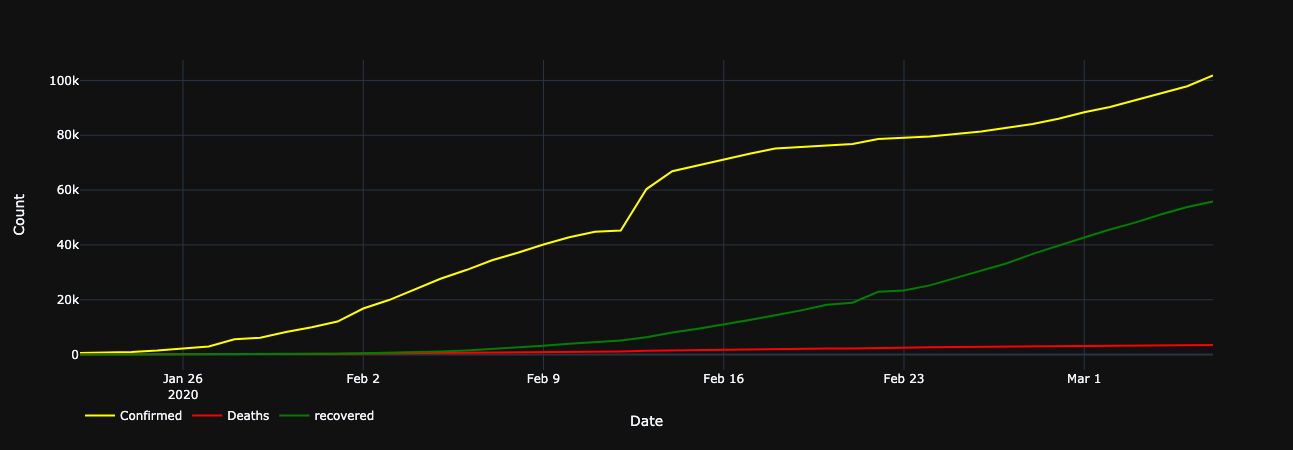

In [18]:
fig = plot_timeseries(corona_sums)
fig.show()

### 2.2. Animated Time series Map
Now let's create the spatial time series of the confirmed cases. So that we can see how the virus is spreading throughout the world by time. Here I am using buble maps, where the size of bubles represents to the value it shows.

In [19]:
import plotly_express as px

tsmap_corona = df_corona[df_corona['type']=='Confirmed']
tsmap_corona['Date'] = tsmap_corona['Date'].astype(str)

/Users/babak.jfard/anaconda3/envs/scipygeo18/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



To control the sizes of bubles I create a categorical column in the following code and relate the sizes of the bubbles to seven classes of data. You may realize that I have hard coded the cut values for bins. This is to prevent adding new material into this post. I would suggest to use standard methods to calculate this cut values. [Here](https://www.axismaps.com/guide/data/data-classification/) is a link to learn about the data classification for creating maps. Also for doing that in python you may consider using _[mapclassify](https://github.com/pysal/mapclassify)_ library in python.

In [20]:
# Classifying data for visulalization
to_Category = pd.cut(tsmap_corona['Count'], [-1,0,105, 361, 760, 1350, 6280, 200000], labels=[0, 1, 8, 25, 40, 60, 100])
tsmap_corona = tsmap_corona.assign(size=to_Category)
tsmap_corona

,Province/State,Country/Region,Lat,Long,Date,type,Count,size
0,Anhui,Mainland China,31.8257,117.2264,2020-01-22,Confirmed,1,1
1,Beijing,Mainland China,40.1824,116.4142,2020-01-22,Confirmed,14,1
2,Chongqing,Mainland China,30.0572,107.8740,2020-01-22,Confirmed,6,1
3,Fujian,Mainland China,26.0789,117.9874,2020-01-22,Confirmed,1,1
4,Gansu,Mainland China,36.0611,103.8343,2020-01-22,Confirmed,0,0
...,...,...,...,...,...,...,...,...
8950,"Ramsey County, MN",US,44.9964,-93.0616,2020-03-06,Confirmed,1,1
8951,"Washoe County, NV",US,40.5608,-119.6035,2020-03-06,Confirmed,1,1
8952,"Wayne County, PA",US,41.6739,-75.2479,2020-03-06,Confirmed,1,1
8953,"Yolo County, CA",US,38.7646,-121.9018,2020-03-06,Confirmed,1,1


And our spatial timeseries map:

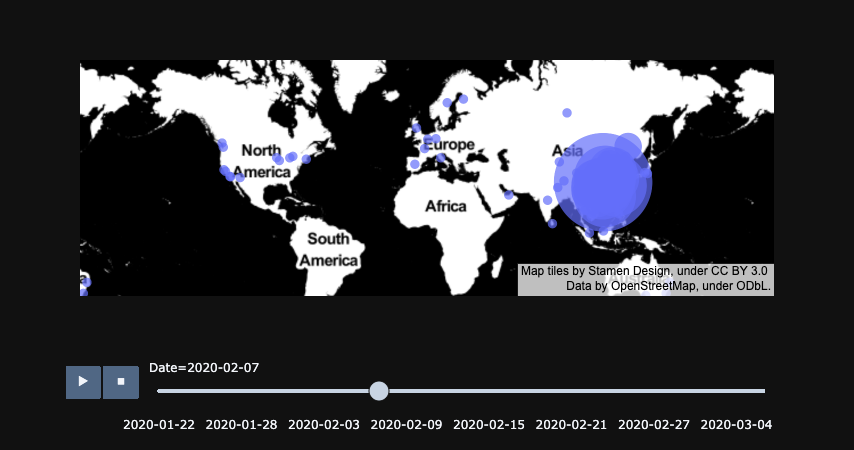

In [21]:
fig_time= px.scatter_mapbox(data_frame=test2, lat='Lat', lon='Long',
hover_name= 'Country/Region', hover_data=['Province/State', 'Count'], size='size', animation_frame='Date', mapbox_style='stamen-toner', template='plotly_dark', zoom=1, size_max=70)
fig_time.show()

That's it. I hope this post has been useful for you. I would appreciate your thoughts, suggestions and any comments you might have for this post.

Babak

In [11]:
# Saving into HTML
import plotly.io as pio
pio.write_html(fig_time, file='/Users/babak.jfard/BabaksPage/public/2020/03/animation/index.html', auto_open=True)